In [1]:
# 1. Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
import ppscore as pps

In [4]:
# 2. Load Dataset
# ============================================
df = pd.read_csv("adult_with_headers.csv")

# Display basic info
print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (32561, 15)


/usr/local/lib/python3.12/dist-packages/google/colab/_interactive_table_hint_button.py:178: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  df_html=dataframe._repr_html_(),  # pylint: disable=protected-access
/usr/local/lib/python3.12/dist-packages/google/colab/_interactive_table_hint_button.py:178: FutureWarning: RangeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  df_html=dataframe._repr_html_(),  # pylint: disable=protected-access


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
# 3. Basic Data Exploration
# ============================================
print("\n--- Data Types ---\n", df.dtypes)
print("\n--- Summary Statistics ---\n", df.describe(include='all'))
print("\n--- Missing Values ---\n", df.isnull().sum())

# Handling missing values (if any)
df = df.dropna()  # you can also choose imputation
print("After handling missing values:", df.shape)


--- Data Types ---
 age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income            object
dtype: object

--- Summary Statistics ---
                  age workclass        fnlwgt education  education_num   
count   32561.000000     32561  3.256100e+04     32561   32561.000000  \
unique           NaN         9           NaN        16            NaN   
top              NaN   Private           NaN   HS-grad            NaN   
freq             NaN     22696           NaN     10501            NaN   
mean       38.581647       NaN  1.897784e+05       NaN      10.080679   
std        13.640433       NaN  1.055500e+05       NaN       2.572720   
min        17.000000       NaN  1.228500e+04      

In [6]:
# 4. Scaling Techniques
# ============================================
# Select numeric columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Standard Scaling
scaler_std = StandardScaler()
df_std = df.copy()
df_std[num_cols] = scaler_std.fit_transform(df_std[num_cols])

# Min-Max Scaling
scaler_mm = MinMaxScaler()
df_mm = df.copy()
df_mm[num_cols] = scaler_mm.fit_transform(df_mm[num_cols])

print("\nStandard Scaling and Min-Max Scaling applied successfully!")


Standard Scaling and Min-Max Scaling applied successfully!


# Markdown: Discussion
"""
### When to use each scaling:
- **StandardScaler:** Best when data follows a normal (Gaussian) distribution.
- **MinMaxScaler:** Useful for algorithms sensitive to magnitude (like neural networks) and data not normally distributed.
"""


In [7]:
# 5. Encoding Techniques
# ============================================
df_encoded = df.copy()

for col in df_encoded.select_dtypes(include='object').columns:
    if df_encoded[col].nunique() <= 5:
        df_encoded = pd.get_dummies(df_encoded, columns=[col], drop_first=True)
    else:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])

print("Encoding complete. New shape:", df_encoded.shape)

Encoding complete. New shape: (32561, 18)


# Markdown: Discussion
"""
### Encoding Discussion
- **One-Hot Encoding:** Captures non-ordinal relationships, increases dimensionality.
- **Label Encoding:** Suitable for ordinal or high-cardinality features but may introduce bias in non-ordinal cases.
"""

In [8]:
# 6. Feature Engineering
# ============================================
df_engineered = df_encoded.copy()

# Example 1: Create "age_group"
df_engineered['age_group'] = pd.cut(df['age'], bins=[0, 25, 45, 65, 100], labels=['Young', 'Adult', 'Mid-age', 'Senior'])

# Example 2: Interaction feature (hours-per-week * education-num)
if 'hours-per-week' in df.columns and 'education-num' in df.columns:
    df_engineered['work_edu_interaction'] = df['hours-per-week'] * df['education-num']

# Log transform skewed column (e.g., 'capital-gain' if present)
if 'capital-gain' in df.columns:
    df_engineered['capital-gain-log'] = np.log1p(df['capital-gain'])

print("Feature engineering complete. New columns added.")

Feature engineering complete. New columns added.


In [9]:
# 7. Feature Selection - Outlier Removal (Isolation Forest)
# ============================================
iso = IsolationForest(contamination=0.02, random_state=42)
outliers = iso.fit_predict(df_engineered[num_cols])
df_no_outliers = df_engineered[outliers == 1]
print("After removing outliers:", df_no_outliers.shape)

After removing outliers: (31909, 19)


# Markdown: Discussion
"""
### Outlier Impact:
Outliers can distort mean, scale, and relationships, leading to poor model generalization.
Isolation Forest isolates anomalies based on fewer random splits, effectively detecting global and local outliers.
"""

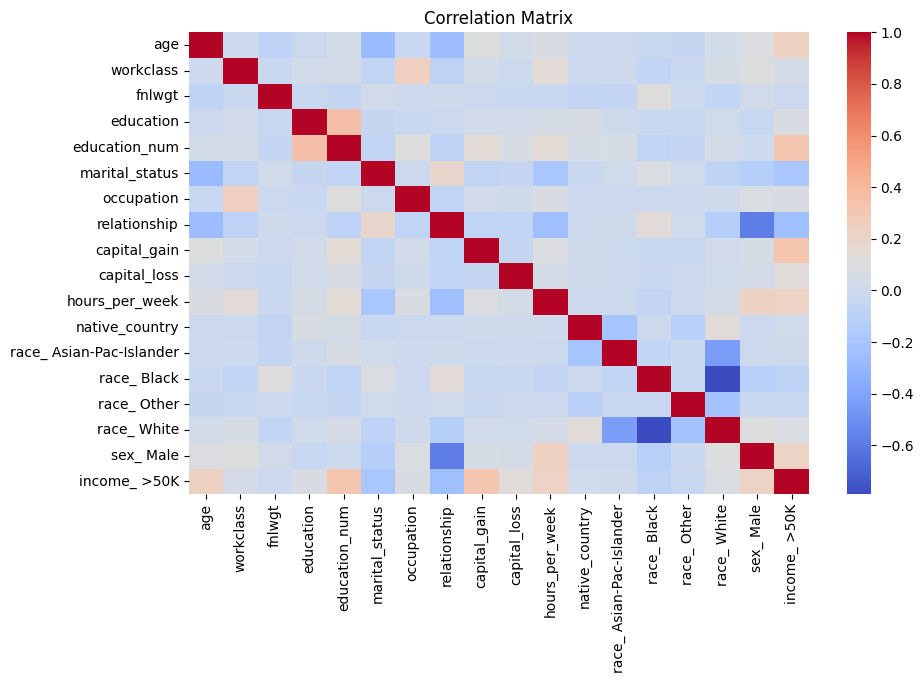

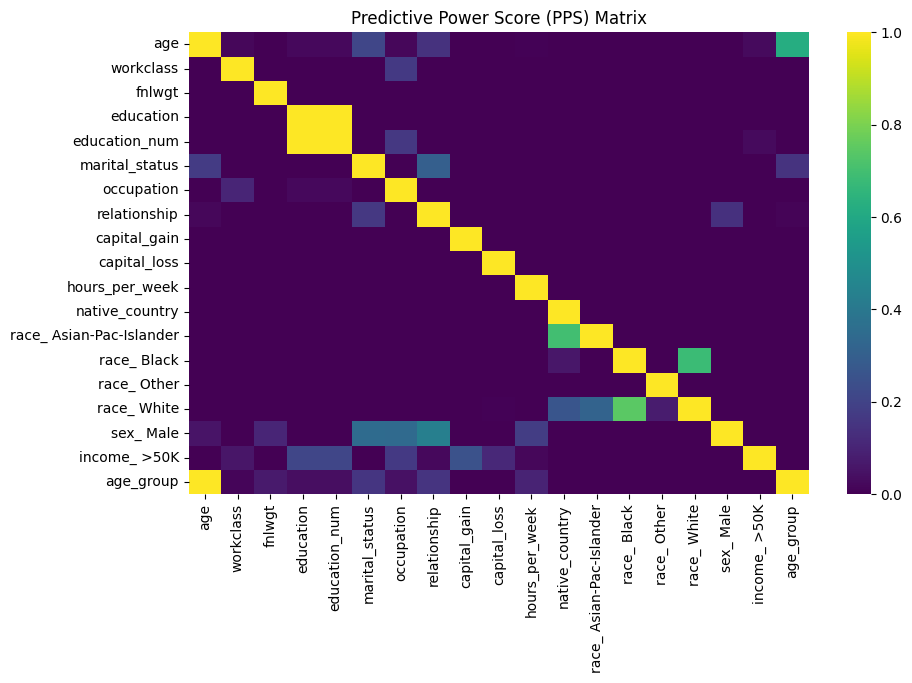

In [11]:
# 8. Feature Relationship Analysis (PPS & Correlation)
# ============================================
pps_matrix = pps.matrix(df_no_outliers)
corr_matrix = df_no_outliers.corr(numeric_only=True)

# Display heatmaps
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Manually restructure pps_matrix for heatmap
pps_pivot_data = {}
for index, row in pps_matrix.iterrows():
    x = row['x']
    y = row['y']
    score = row['ppscore']
    if x not in pps_pivot_data:
        pps_pivot_data[x] = {}
    pps_pivot_data[x][y] = score

pps_pivot = pd.DataFrame(pps_pivot_data)

plt.figure(figsize=(10,6))
sns.heatmap(pps_pivot, cmap='viridis')
plt.title("Predictive Power Score (PPS) Matrix")
plt.show()

# Markdown: Discussion
"""
### PPS vs Correlation
- **Correlation** captures linear relationships.
- **PPS** captures both linear and non-linear predictive relationships.
Using both gives deeper insight into feature interactions and importance.
"""